# Revisiting a Classic Cheminformatics Paper: The Wiener Index

Harry Wiener was "[a pioneer in cheminformatics and chemical graph theory](https://en.wikipedia.org/wiki/Harry_Wiener)". In his 1947 _Journal of the American Chemical Society_ article "[Structural Determination of Paraffin Boiling Points](https://pubs.acs.org/doi/10.1021/ja01193a005)", he introduced the path number $\omega$ "as the sum of the distances between any two carbon atoms in the molecule, in terms of carbon-carbon bonds", which is now known as the Wiener index. He used his index to model the boiling points of alkanes (also known as paraffins). This post revisits that article, extracts data for molecules from it, recalculates cheminformatics parameters and boiling points, and plots the data.

In addition to the Wiener index, Wiener's paper defines another cheminformatic parameter, the polarity number $p$, as "the number of pairs of carbon atoms which are separated by three carbon-carbon bonds."

His paper is impressive for the density of data--much of the paper is tables of data--and discovering cheminformatics parameters that model physical data with simple relationships. The [Wiener index has been generalized and applied to bioactivity and materials](https://en.wikipedia.org/wiki/Harry_Wiener#Achievements).

## Models From Wiener's Paper

Wiener models the boiling points of alkanes using the linear formula

$t_{B} = a\omega + bp + c$ (eqn 1)

where $t_{B}$ is the boiling point in degrees Celcius. He simplifies the problem by calculating deltas (differences) for each molecule's $\omega$ and $p$ compared to its straight-chain alkane with the same number of carbons, that is, its structural isomer. For example, the base molecule for 2-methylhexane and 2,2,3-trimethylbutane is $n$-heptane. Deltas are calculated as for example $\Delta\omega = \omega_{0} - \omega$ where $\omega_{0}$ refers to the base molecule, for example $n$-heptane, and $\omega$ refers to the molecule in question, for example 2-methylhexane. This transforms eqn 1 to

$\Delta t = a\Delta\omega + b\Delta p$ (eqn 2)

Wiener determines that the eqn 2 fits the data if $\Delta\omega$ is divided by $n^{2}$, so he rewrites eqn 2 as

$\Delta t = \frac{k}{n^{2}}\Delta\omega + b\Delta p$ (eqn 3)

and fits it to the data to determine that $k$ = 98 and b = 5.5:

$\Delta t = \frac{98}{n^{2}}\Delta\omega + 5.5\Delta p$ (eqn 4)

$\omega$ and $p$ are cheminformatic parameters than can be calculated from the molecular graph. The boiling point of the straight-chain alkanes needs to be empirically modeled, and [Egloff's equation](https://pubs.acs.org/doi/10.1021/j150402a006) neatly expresses those boiling points in terms of only the number of carbons $n$:

$t_{0} = 745.42 \log(n + 4.4) - 689.4$ (eqn 5)

## Approach Used in This Blog Post

With the availability of open-source cheminformatics software such as RDKit, it becomes a matter of reading in the molecules and their observed boiling points from Wiener's paper, converting the molecules' names to structures, calculating $\Delta\omega$ and $\Delta p$, then $\Delta t$ values. We can then plot the results to visualize how well Wiener's eqn 4 fits the experimental data and identify trends.

My approach was to import the data from the paper's tables as easily as possible:
- For tables with little data and simple patterns, namely table I, I entered it manually.
- For tables with a lot of data (tables II and III), I decided the easier and less error-prone approach was to automatically extract the data from a PDF of the article. The American Chemical Society used optical character recognition (OCR) to digitize the image of the paper, which led to errors in chemical names. I then used [pypdf](https://pypi.org/project/pypdf/) to extract the text. I manually copied the data for each of those tables into its own text file, then fixed some issues due to formatting in the original paper. I saved those tables as text files, then read their data in as lists, then fixed the typos.

The key packages this post uses are:
- [py2opsin](https://github.com/JacksonBurns/py2opsin) to convert chemical names into SMILES strings. This very convenient Python interface to [OPSIN - Open Parser for Systematic IUPAC Nomenclature](https://github.com/dan2097/opsin) means we don't need to make time-consuming calls to a web-based API such as PubChem, which was necessary in [my last blog post to determine the commercial availability of molecules](https://bertiewooster.github.io/2023/02/07/Are-the-Starting-Materials-for-Synthesizing-Your-Target-Molecules-Commercially-Available.html) because commercial availability varies over time.
- [RDKit](https://www.rdkit.org/) to convert SMILES strings into molecules and calculate their cheminformatic parameters
- [Polars](https://www.pola.rs/) to track the information for the molecules in DataFrames. Polars is a lightning-fast alternative to [pandas](https://pandas.pydata.org/), the classic Python DataFrame package.
- [seaborn](https://seaborn.pydata.org/) and [matplotlib](https://matplotlib.org/) to plot the results
- [mol_frame](https://github.com/apahl/mol_frame) to show images of molecules when you mouse over them on a graph

## Code Foundation

In [1]:
# Mount Google Drive so can read in Wiener's tables
# and format code in this notebook using black
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%%capture
%pip install polars
%pip install rdkit
%pip install seaborn
%pip install numpy
%pip install py2opsin
%pip install black[jupyter]

In [3]:
# For mol_frame
%%capture
%pip install git+https://github.com/apahl/mol_frame

from mol_frame import mol_frame as mf
import os, holoviews as hv

os.environ["HV_DOC_HTML"] = "true"

In [4]:
# Format code using black
# procedure at https://stackoverflow.com/questions/63076002/code-formatter-like-nb-black-for-google-colab#71001241
!black "/content/drive/MyDrive/Colab Notebooks/RevisitingWiener.ipynb"

All done! ✨ 🍰 ✨
1 file left unchanged.


In [5]:
import math

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn
from py2opsin import py2opsin
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import IPythonConsole

In [35]:
# Cheminformatic utilities
def wiener_index(m: Chem.Mol):
    """
    From https://sourceforge.net/p/rdkit/mailman/message/36802142/ by Greg Landrum
    :returns: Wiener index, aka path number
    :rtype: int
    :param m: RDKit molecule
    """
    res = 0
    amat = Chem.GetDistanceMatrix(m)
    num_atoms = m.GetNumAtoms()
    for i in range(num_atoms):
        for j in range(i + 1, num_atoms):
            res += amat[i][j]
    return int(res)


def CalculatePolarityNumber(mol: Chem.Mol) -> int:
    """
    #################################################################
    Copyright BSD 3-Clause "New" or "Revised" License
    Author : gadsbyfly
    https://codesuche.com/view-source/python/gadsbyfly/PyBioMed/

    Calculation of Polarity number.
    It is the number of pairs of vertexes at
    distance matrix equal to 3
    ---->Pol
    Usage:
        result=CalculatePolarityNumber(mol)
        Input: mol is a molecule object
        Output: result is a numeric value
    #################################################################
    """
    Distance = Chem.GetDistanceMatrix(mol)
    res = int(1.0 / 2 * sum(sum(Distance == 3)))

    return res


def calc_Δt(n: int | pl.Expr, Δomega: int | pl.Expr, Δp: int | pl.Expr) -> float:
    """
    Calculate Δt using Wiener equation 4
    https://pubs.acs.org/doi/10.1021/ja01193a005
    :returns: Δt, difference in boiling point between alkane and its structral
    isomer of a linear alkane
    :param n: number of carbon atoms
    :param Δomega: Wiener index of straight-chain alkane minus this molecule
    :param Δp: polarity number of straight-chain alkane minus this molecule
    """
    return (98 / (n**2) * Δomega) + (5.5 * Δp)


def egloff(n: int) -> float:
    """
    Calculate boiling point for linear alkane using Egloff's equation
    https://pubs.acs.org/doi/pdf/10.1021/j150402a006
    :returns: t, boiling point for a linear alkane
    :param n: number of carbon atoms
    """
    return 745.42 * math.log10(n + 4.4) - 689.4

## Digitizing Wiener's Data

We start by reading in the data from tables II and III, stored in text files. Because they were digitized using OCR, there are several misinterpreted characters to correct.

In [36]:
molecules = []
tables = []
ts_read_in = []
ts_which = []

# Dictionary of typos and corrections.
#   Italicized "n" in "n-" is particularly difficult for OCR.
replace_typos = {
    "w-": "n-",
    "ro-": "n-",
    "«-": "n-",
    "^": "2",
    "!": "l",
    "thyI": "thyl",
    "Methyt": "Methyl",
    "raethyl": "methyl",
    "pentaue": "pentane",
}

for table_num in ("II", "III"):
    table_file = f"/content/drive/MyDrive/data/wiener_table_{table_num}_edited.txt"
    with open(table_file) as f:
        content = f.readlines()

        # Ignore lines that start with period or comma--
        #   these were incorrectly split across two lines
        ignore_line_chars = (".", ",")

        for line in content:
            if line[0] not in ignore_line_chars:
                line_clean = line
                for typo, correct in replace_typos.items():
                    line_clean = line_clean.replace(typo, correct)
                end_marker = "ane "
                end_of_molecule = line_clean.find(end_marker) + len(end_marker)
                no_spaces_in_molecule = line_clean[:end_of_molecule].replace(" ", "")
                words = line_clean[end_of_molecule:].split()
                t_read_in = words[0]

                # Some table entries have no observed data;
                #   we process only molecules with observed data
                if t_read_in != "Null":
                    molecules.append(no_spaces_in_molecule)
                    tables.append(table_num)
                    ts_read_in.append(float(t_read_in))
                    if table_num == "II":
                        ts_which.append("Δt")
                    elif table_num == "III":
                        ts_which.append("t")

To convert the chemical names to SMILES strings so they can be interpreted by RDKit as molecules, the name parser [py2opsin](https://github.com/JacksonBurns/py2opsin) saves us from having to make API calls to a web site, which would be slow.

In [37]:
smiles = py2opsin(molecules)

We create the Polars dataframe with the information we have now, and will add to the dataframe later. Polars provides a nice table printout for a dataframe.

In [38]:
df = pl.DataFrame(
    {
        "molecule": molecules,
        "table": tables,
        "Smiles": smiles,
        "t_read_in": ts_read_in,
        "t_which": ts_which,
    }
)
df = df.with_row_count(name="Compound_Id", offset=1)

print(df)

shape: (94, 6)
┌─────────────┬────────────────────────────┬───────┬────────────────────┬───────────┬─────────┐
│ Compound_Id ┆ molecule                   ┆ table ┆ Smiles             ┆ t_read_in ┆ t_which │
│ ---         ┆ ---                        ┆ ---   ┆ ---                ┆ ---       ┆ ---     │
│ u32         ┆ str                        ┆ str   ┆ str                ┆ f64       ┆ str     │
╞═════════════╪════════════════════════════╪═══════╪════════════════════╪═══════════╪═════════╡
│ 1           ┆ n-Butane                   ┆ II    ┆ CCCC               ┆ 0.0       ┆ Δt      │
│ 2           ┆ 2-Methylpropane            ┆ II    ┆ CC(C)C             ┆ 11.2      ┆ Δt      │
│ 3           ┆ n-Pentane                  ┆ II    ┆ CCCCC              ┆ 0.0       ┆ Δt      │
│ 4           ┆ 2-Methylbutane             ┆ II    ┆ CC(C)CC            ┆ 8.2       ┆ Δt      │
│ …           ┆ …                          ┆ …     ┆ …                  ┆ …         ┆ …       │
│ 91          ┆ 2,2-Dimet

The first crucial step is to convert each SMILES string to a molecule. If there any remaining typos in the chemical names, py2opsin might be unable to parse the names into SMILES strings and would give an empty string. RDKit would create an empty molecule (with no atoms), but we would run into problems in the subsequent step when we tried to calculate the Wiener index or polarity number because the molecule has no [distance matrix](https://www.rdkit.org/docs/source/rdkit.Chem.rdmolops.html?highlight=getdistancematrix#rdkit.Chem.rdmolops.GetDistanceMatrix).

To avoid storing Python objects in the dataframe, which uses extra memory, we create a function `mol_props` to convert a SMILES string into a molecule, and then return all the desired molecular properties (canonical SMILES, omega, p, and n) as a dictionary. That data is added to the Polars dataframe as a [struct column](https://docs.pola.rs/user-guide/expressions/structs/#encountering-the-struct-type), which we can then [`unnest`](https://docs.pola.rs/docs/python/dev/reference/dataframe/api/polars.DataFrame.unnest.html#polars.DataFrame.unnest) to produce a column for each molecular property.

In [39]:
def mol_props(sml):
    """
    Convert SMILES to an RDKit molecule, then calculate various properties of it
    :returns: dictionary of molecular properties
    :param sml: SMILES to convert to a molecule
    """
    mol = Chem.MolFromSmiles(sml)
    CanonicalSMILES = Chem.MolToSmiles(mol)
    omega = wiener_index(mol)
    p = CalculatePolarityNumber(mol)
    n = mol.GetNumAtoms()
    return dict(
        CanonicalSMILES=CanonicalSMILES,
        omega=omega,
        p=p,
        n=n,
        )

df = df.with_columns(
   molecular_props = pl.col('Smiles').map_elements(mol_props)
).unnest('molecular_props')
df

Compound_Id,molecule,table,Smiles,t_read_in,t_which,CanonicalSMILES,omega,p,n
u32,str,str,str,f64,str,str,i64,i64,i64
1,"""n-Butane""","""II""","""CCCC""",0.0,"""Δt""","""CCCC""",10,1,4
2,"""2-Methylpropan…","""II""","""CC(C)C""",11.2,"""Δt""","""CC(C)C""",9,0,4
3,"""n-Pentane""","""II""","""CCCCC""",0.0,"""Δt""","""CCCCC""",20,2,5
4,"""2-Methylbutane…","""II""","""CC(C)CC""",8.2,"""Δt""","""CCC(C)C""",18,2,5
5,"""2,2-Dimethylpr…","""II""","""CC(C)(C)C""",26.6,"""Δt""","""CC(C)(C)C""",16,0,5
6,"""n-Hexane""","""II""","""CCCCCC""",0.0,"""Δt""","""CCCCCC""",35,3,6
7,"""2-Methylpentan…","""II""","""CC(C)CCC""",8.5,"""Δt""","""CCCC(C)C""",32,3,6
8,"""3-Methylpentan…","""II""","""CC(CC)CC""",5.4,"""Δt""","""CCC(C)CC""",31,4,6
9,"""2,2-Dimethylbu…","""II""","""CC(C)(CC)C""",19.0,"""Δt""","""CCC(C)(C)C""",28,3,6


## Calculating the Wiener Index and Other Cheminformatic Parameters

Now that we have RDKit molecules, we can use RDKit's cheminformatic functions to get the canonical SMILES, molecular weight, and number of atoms (by default, RDKit excludes hydrogen atoms from molecules, so GetNumAtons gives the number of carbon atoms). We call the utility functions above to get the cheminformatic parameters from Wiener's paper: Wiener index and polarity number.

Because Wiener frames values for each structural isomer as deltas from the corresponding linear alkane, we need to reference the corresponding linear alkane for each molecule. We can create a table for the linear alkanes, then join that to the table of all molecules based on the number of carbon atoms, $n$. The `linear_alkanes` dataframe comes from Wiener's table I. The data were so quick to enter that I did so manually rather than use py2opsin to determine SMILES strings, etc. as above.

In [40]:
linear_alkanes = pl.DataFrame(
    {
        "molecule": [
            "n-Butane",
            "n-Pentane",
            "n-Hexane",
            "n-Heptane",
            "n-Octane",
            "n-Nonane",
            "n-Decane",
            "n-Undecane",
            "n-Dodecane",
        ],
        "t0_obs °C": [-0.5, 36.1, 68.7, 98.4, 125.7, 150.8, 174.0, 195.8, 216.2],
        "Smiles": [
            "CCCC",
            "CCCCC",
            "CCCCCC",
            "CCCCCCC",
            "CCCCCCCC",
            "CCCCCCCCC",
            "CCCCCCCCCC",
            "CCCCCCCCCCC",
            "CCCCCCCCCCCC",
        ],
        "n": [4, 5, 6, 7, 8, 9, 10, 11, 12],
        "omega0": [10, 20, 35, 56, 84, 120, 165, 220, 286],
        "p0": [1, 2, 3, 4, 5, 6, 7, 8, 9],
        "Compound_Id": [4, 5, 6, 7, 8, 9, 10, 11, 12],
    }
)

linear_alkanes = linear_alkanes.with_columns(
        pl.col("n").map_elements(egloff).alias("t0_calc"),
)
linear_alkanes

molecule,t0_obs °C,Smiles,n,omega0,p0,Compound_Id,t0_calc
str,f64,str,i64,i64,i64,i64,f64
"""n-Butane""",-0.5,"""CCCC""",4,10,1,4,-0.423735
"""n-Pentane""",36.1,"""CCCCC""",5,20,2,5,35.988965
"""n-Hexane""",68.7,"""CCCCCC""",6,35,3,6,68.716992
"""n-Heptane""",98.4,"""CCCCCCC""",7,56,4,7,98.438014
"""n-Octane""",125.7,"""CCCCCCCC""",8,84,5,8,125.658393
"""n-Nonane""",150.8,"""CCCCCCCCC""",9,120,6,9,150.766459
"""n-Decane""",174.0,"""CCCCCCCCCC""",10,165,7,10,174.066569
"""n-Undecane""",195.8,"""CCCCCCCCCCC""",11,220,8,11,195.801696
"""n-Dodecane""",216.2,"""CCCCCCCCCCCC""",12,286,9,12,216.168901


[Polars' join](https://pola-rs.github.io/polars-book/user-guide/howcani/combining_data/joining.html) syntax is similar to SQL: You state which field to join on (here, $n$), and the join type (inner) as `how`.

In [41]:
# Join to copy in values from corresponding straight-chain alkane
df = df.join(linear_alkanes, on="n", how="inner", suffix="_lin_alkane")

Now that we have the base data for each molecule's corresponding linear alkane, we can calculate deltas. Wiener gave observed $Δt$ values in table II and $t$ values in table III. So we have to use Polars' [when-then-otherwise](https://pola-rs.github.io/polars-book/user-guide/dsl/expressions.html#binary-functions-and-modification) functionality to check what type of value was read in. We also use Polars' [`struct`](https://pola-rs.github.io/polars-book/user-guide/dsl/custom_functions.html?highlight=struct#combining-multiple-column-values) to use multiple input columns to calculate an output column.

In [42]:
df = df.with_columns(
    [
        # Conditional: If t_read is delta vs. t (absolute)
        pl.when(pl.col("t_which") == "t")
        .then(pl.col("t_read_in"))
        .otherwise(
            (pl.col("t0_obs °C") - pl.col("t_read_in"))
        )
        .alias("t_obs °C"),
    ]
)

# Show relevant columns to check our work
row_t = df.select(["molecule", "t_read_in", "t_which", "t0_obs °C", "t_obs °C"])
print(row_t)

shape: (94, 5)
┌────────────────────────────┬───────────┬─────────┬───────────┬──────────┐
│ molecule                   ┆ t_read_in ┆ t_which ┆ t0_obs °C ┆ t_obs °C │
│ ---                        ┆ ---       ┆ ---     ┆ ---       ┆ ---      │
│ str                        ┆ f64       ┆ str     ┆ f64       ┆ f64      │
╞════════════════════════════╪═══════════╪═════════╪═══════════╪══════════╡
│ n-Butane                   ┆ 0.0       ┆ Δt      ┆ -0.5      ┆ -0.5     │
│ 2-Methylpropane            ┆ 11.2      ┆ Δt      ┆ -0.5      ┆ -11.7    │
│ n-Pentane                  ┆ 0.0       ┆ Δt      ┆ 36.1      ┆ 36.1     │
│ 2-Methylbutane             ┆ 8.2       ┆ Δt      ┆ 36.1      ┆ 27.9     │
│ …                          ┆ …         ┆ …       ┆ …         ┆ …        │
│ 2,2-Dimethyl-4-ethylhexane ┆ 148.0     ┆ t       ┆ 174.0     ┆ 148.0    │
│ 2,2,3,4-Tetramethylhexane  ┆ 156.5     ┆ t       ┆ 174.0     ┆ 156.5    │
│ 2,2,4,5-Tetramethylhexane  ┆ 145.8     ┆ t       ┆ 174.0     ┆ 145.8   

In [43]:
df = df.with_columns(
    [
        # Calculate Δt_obs °C
        (pl.col("t0_obs °C") - pl.col("t_obs °C"))
        .alias("Δt_obs °C")
    ]
)
row_t = df.select(
    ["molecule", "t_read_in", "t_which", "t0_obs °C", "t_obs °C", "Δt_obs °C"]
)

print(row_t)

shape: (94, 6)
┌────────────────────────────┬───────────┬─────────┬───────────┬──────────┬───────────┐
│ molecule                   ┆ t_read_in ┆ t_which ┆ t0_obs °C ┆ t_obs °C ┆ Δt_obs °C │
│ ---                        ┆ ---       ┆ ---     ┆ ---       ┆ ---      ┆ ---       │
│ str                        ┆ f64       ┆ str     ┆ f64       ┆ f64      ┆ f64       │
╞════════════════════════════╪═══════════╪═════════╪═══════════╪══════════╪═══════════╡
│ n-Butane                   ┆ 0.0       ┆ Δt      ┆ -0.5      ┆ -0.5     ┆ 0.0       │
│ 2-Methylpropane            ┆ 11.2      ┆ Δt      ┆ -0.5      ┆ -11.7    ┆ 11.2      │
│ n-Pentane                  ┆ 0.0       ┆ Δt      ┆ 36.1      ┆ 36.1     ┆ 0.0       │
│ 2-Methylbutane             ┆ 8.2       ┆ Δt      ┆ 36.1      ┆ 27.9     ┆ 8.2       │
│ …                          ┆ …         ┆ …       ┆ …         ┆ …        ┆ …         │
│ 2,2-Dimethyl-4-ethylhexane ┆ 148.0     ┆ t       ┆ 174.0     ┆ 148.0    ┆ 26.0      │
│ 2,2,3,4-Tetrame

Next we calculate the cheminformatic parameters and use them to calculate predicted $Δt$ values. We complete the dataframe by calculating the deviation between the calculated and observed boiling points.

In [44]:
# Calculate delta omega, p values
df = df.with_columns(
    [
        (pl.col("omega0") - pl.col("omega")).alias("Δomega"),
        (pl.col("p0") - pl.col("p")).alias("Δp"),
    ]
)

# Calculate delta t
df = df.with_columns(
        # Use the calc_Δt function directly, passing the columns as arguments
        calc_Δt(pl.col("n"), pl.col("Δomega"), pl.col("Δp")).alias("Δt_calc °C"),
)

df = df.with_columns(
    [
        # Calculate t_calc °C
        (pl.col("t0_calc") - pl.col("Δt_calc °C")).alias("t_calc °C"),
        # Calculate t_obs °C
        (pl.col("t0_obs °C") - pl.col("Δt_obs °C")).alias("t_obs °C"),
        # Calculate deviation in delta t: obs - calc
        (pl.col("Δt_obs °C") - pl.col("Δt_calc °C")).alias("Deviation °C"),
    ]
)

df = df.with_columns(
    [
        # Take absolute value of deviation
        pl.col("Deviation °C").abs().alias("Absolute Deviation °C"),
    ]
)
df.head(3)

Compound_Id,molecule,table,Smiles,t_read_in,t_which,CanonicalSMILES,omega,p,n,molecule_lin_alkane,t0_obs °C,Smiles_lin_alkane,omega0,p0,Compound_Id_lin_alkane,t0_calc,t_obs °C,Δt_obs °C,Δomega,Δp,Δt_calc °C,t_calc °C,Deviation °C,Absolute Deviation °C
u32,str,str,str,f64,str,str,i64,i64,i64,str,f64,str,i64,i64,i64,f64,f64,f64,i64,i64,f64,f64,f64,f64
1,"""n-Butane""","""II""","""CCCC""",0.0,"""Δt""","""CCCC""",10,1,4,"""n-Butane""",-0.5,"""CCCC""",10,1,4,-0.423735,-0.5,0.0,0,0,0.0,-0.423735,0.0,0.0
2,"""2-Methylpropan…","""II""","""CC(C)C""",11.2,"""Δt""","""CC(C)C""",9,0,4,"""n-Butane""",-0.5,"""CCCC""",10,1,4,-0.423735,-11.7,11.2,1,1,11.625,-12.048735,-0.425,0.425
3,"""n-Pentane""","""II""","""CCCCC""",0.0,"""Δt""","""CCCCC""",20,2,5,"""n-Pentane""",36.1,"""CCCCC""",20,2,5,35.988965,36.1,0.0,0,0,0.0,35.988965,0.0,0.0


## Visualizing Egloff's Equation Modeling Boiling Point for Linear Alkanes

In [45]:
# Set up plot axis labels
t_obs_label = "$t_{obs}$ ($^\circ$C)"
t_calc_label = "$t_{calc}$ ($^\circ$C)"
dev_C_label = "$Deviation$ ($^\circ$C)"
n_label = "n (number of carbon atoms)"

# Set matplotlib figure size
plt.rcParams["figure.dpi"] = 150

We start with the baseline of linear alkanes and verify that Egloff's equation fits their boiling points well as a function of number of carbon atoms $n$.

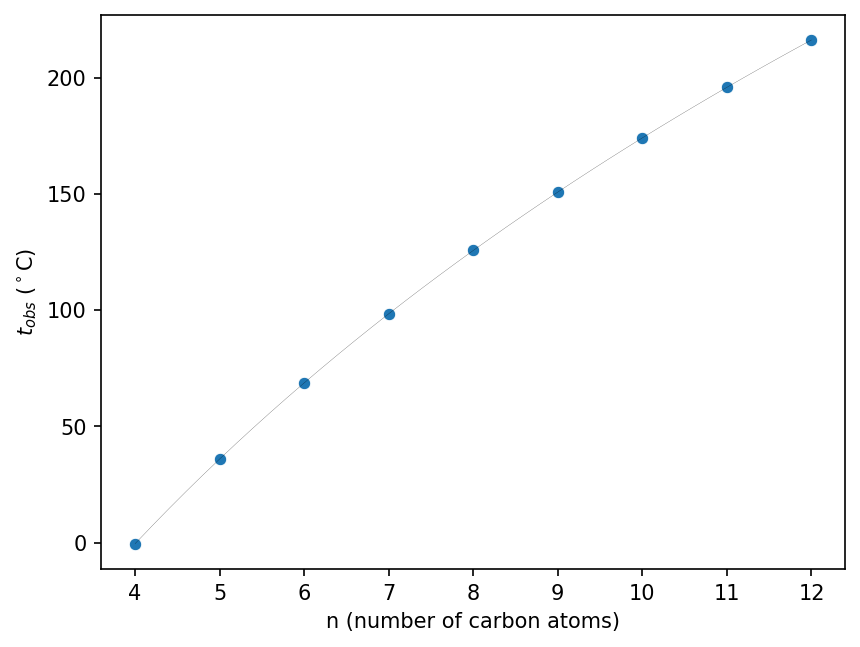

In [46]:
# Convert to pandas manually because automatic conversion fails in Google Colab for some reason
linear_alkanes_pd = linear_alkanes.to_pandas()

# Plot experimental straight-chain alkane data:
#   Boiling point against number of carbons
seaborn.scatterplot(data=linear_alkanes_pd, x="n", y="t0_obs °C")

# Add to the plot a curve for the Egloff model
egloff_x = np.linspace(4, 12, 41)
egloff_y = [egloff(x) for x in egloff_x]
plt.xlabel(n_label)
plt.ylabel(t_obs_label)
plt.plot(egloff_x, egloff_y, color="black", linewidth=0.1)

The [mol_frame package](https://github.com/apahl/mol_frame) lets us show the molecules as pop-ups (tooltips) when we mouse over each data point. We will reproduce each plot as a mol_frame plot. The mol_frame package requires a pandas dataframe.

In [47]:
linear_alkanes_mf = mf.MolFrame(linear_alkanes_pd)
linear_alkanes_mf = linear_alkanes_mf.add_b64()

* using Smiles
* add b64:               (    9 |    9)


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
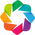

* using Mol_b64
* add img:               (    9 |   10)


:Scatter   [n]   (t0_obs °C,Compound_Id,Image)
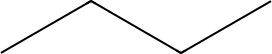
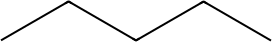
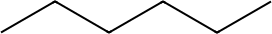

In [48]:
%%output filename="mol_frame_scatter"
hv.extension('bokeh')
linear_alkanes_mf.scatter("n", "t0_obs °C")

## Visualizing Wiener's Model for $Δt$ for Boiling Point of Alkanes

Considering now the substance of the paper, we plot the calculated against observed boiling points for the 94 alkanes. The diagonal line represents a perfect fit of model to experiment.

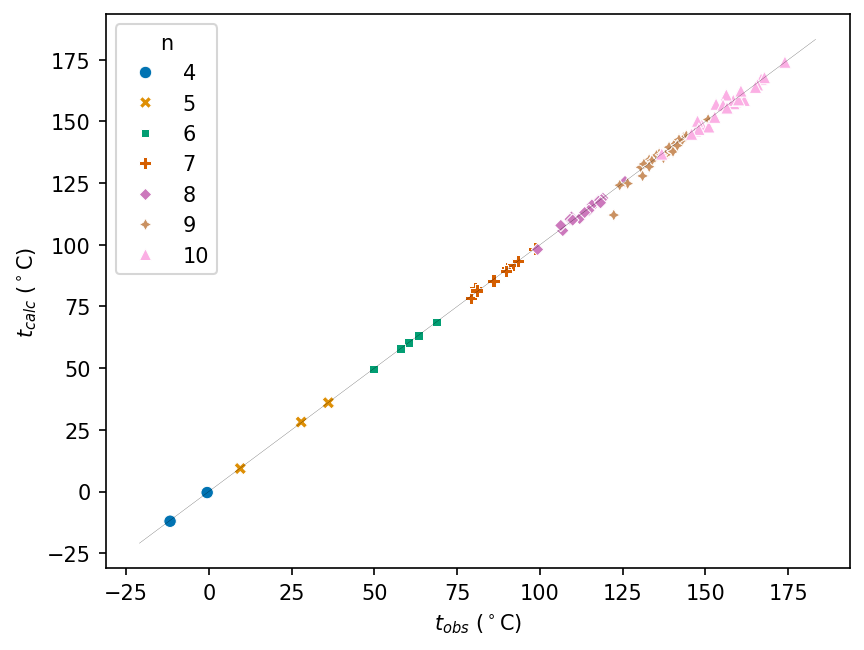

In [49]:
# Convert to pandas manually because automatic conversion fails in Google Colab for some reason
df_pd = df.to_pandas()

# Plot alkane boiling point data: calculated against observed
seaborn.scatterplot(
    data=df_pd, x="t_obs °C", y="t_calc °C", hue="n", palette="colorblind", style="n"
)

plt.xlabel(t_obs_label)
plt.ylabel(t_calc_label)

# Add an equality line representing perfect predictions
#   Set its range using plot's range
x_range = plt.xlim()
y_range = plt.xlim()
equality_range = (min(x_range[0], y_range[0]), max(x_range[1], y_range[1]))

plt.plot(equality_range, equality_range, color="black", linewidth=0.1)

In [50]:
# Prepare dataframe for plotting with mol_frame
df_mf = mf.MolFrame(df_pd)
df_mf = df_mf.add_b64()

* using Smiles
* add b64:               (   94 |   26)


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
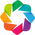

* using Mol_b64
* add img:               (   94 |   27)


:Scatter   [t_obs °C]   (t_calc °C,Compound_Id,Image,n)
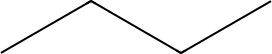
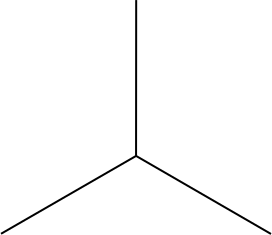
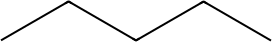
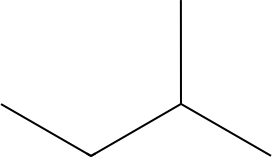
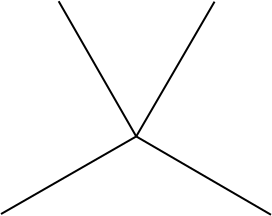
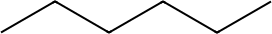
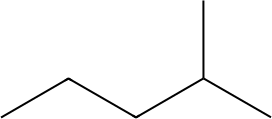
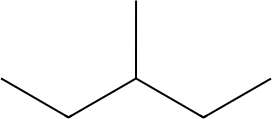
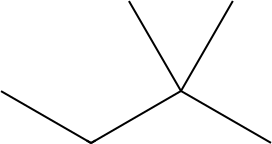
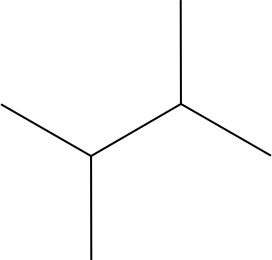
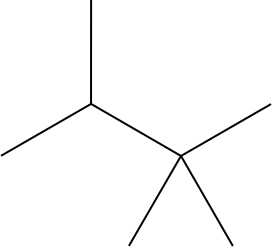
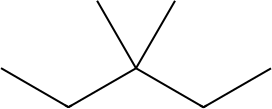
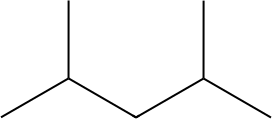
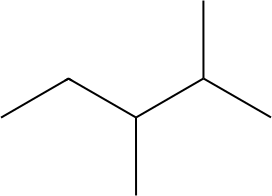
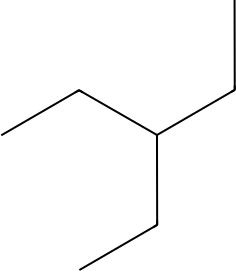
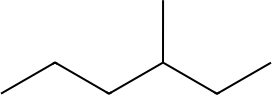
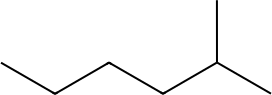
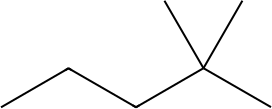
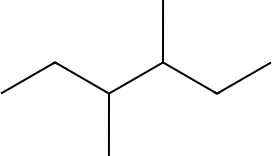
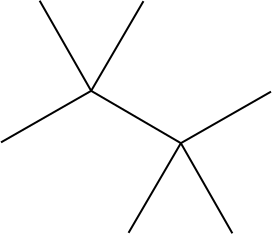
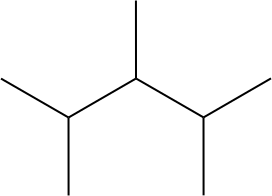
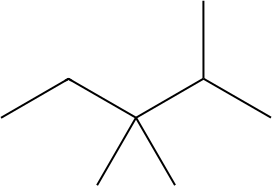
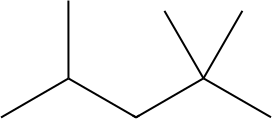
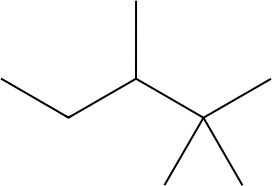
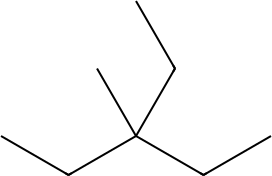
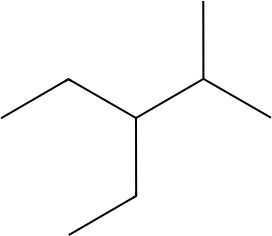
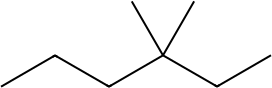
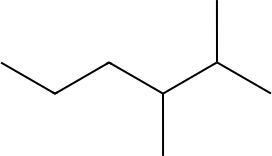
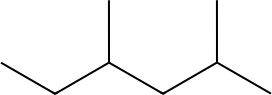
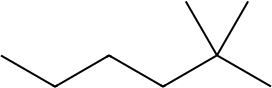
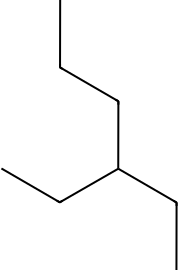
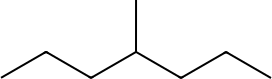
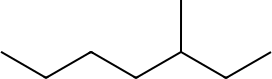
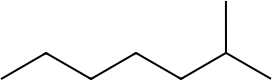
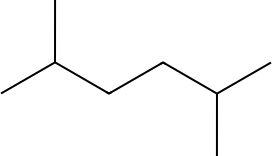
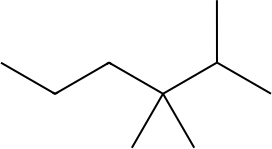
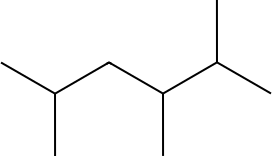
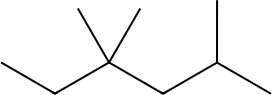
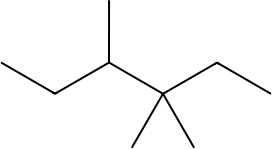
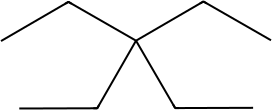
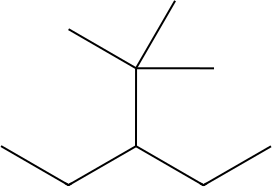
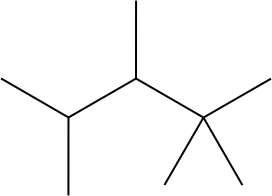
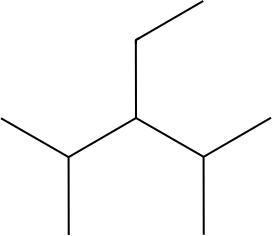
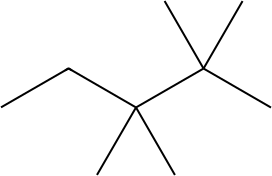
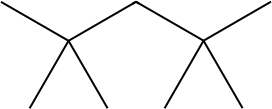
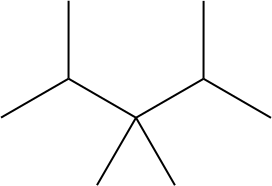
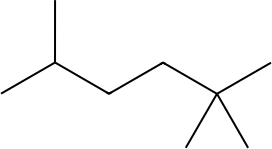
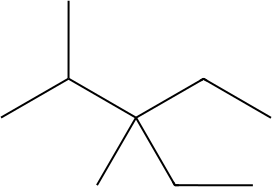
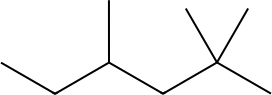
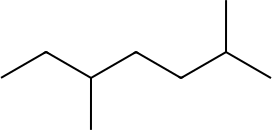
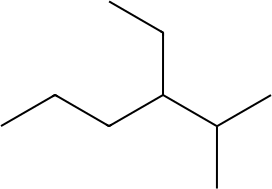
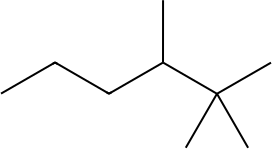
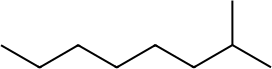
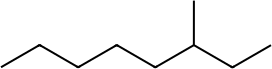
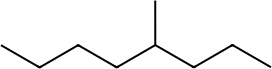
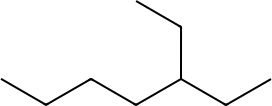
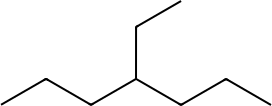
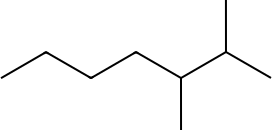
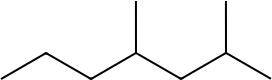
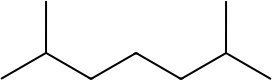
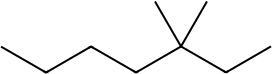
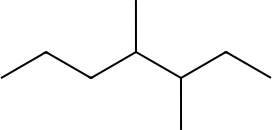
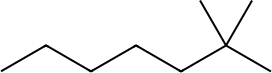
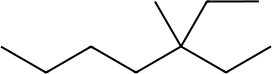
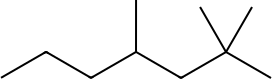
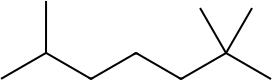
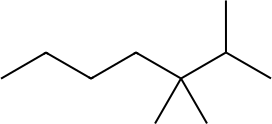
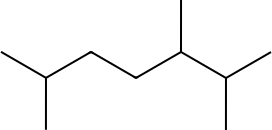
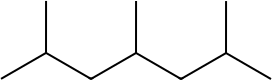
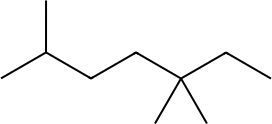
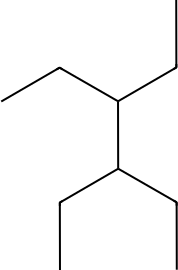
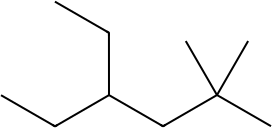
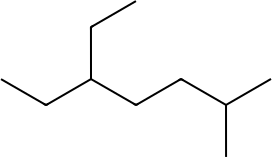
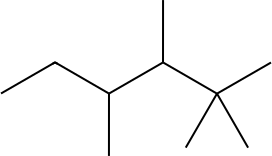
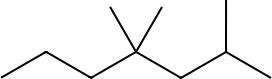
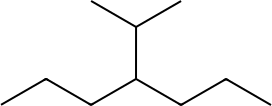
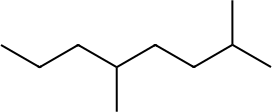
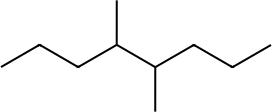
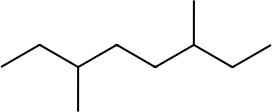
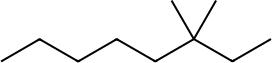
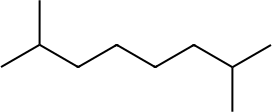
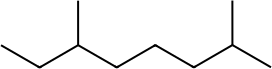
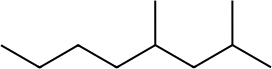
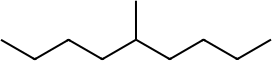
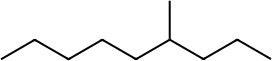
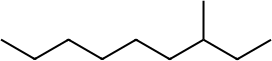
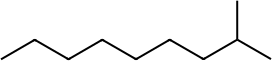
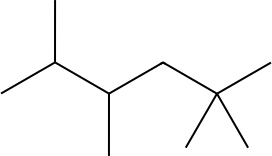
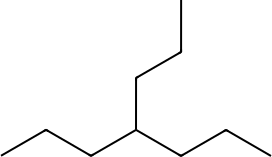
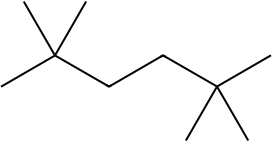

In [51]:
%%output filename="df_mol_frame_scatter"
hv.extension('bokeh')
df_mf.scatter("t_obs °C", "t_calc °C", colorby="n")

The greatest deviations can also be shown in tabluar form using [Polars' filter](https://pola-rs.github.io/polars-book/user-guide/quickstart/quick-exploration-guide.html?highlight=filter#filter) method.

In [52]:
# Identify molecules with the greatest deviation
# --where Wiener's equation 4 is least accurate
row = df.filter(abs(pl.col("Deviation °C")) > 3)
row_t = row.select(
    ["molecule", "t_obs °C", "t_calc °C", "n", "Δomega", "Δp", "Deviation °C"]
)
print(row_t)

shape: (6, 7)
┌────────────────────────────┬──────────┬────────────┬─────┬────────┬─────┬──────────────┐
│ molecule                   ┆ t_obs °C ┆ t_calc °C  ┆ n   ┆ Δomega ┆ Δp  ┆ Deviation °C │
│ ---                        ┆ ---      ┆ ---        ┆ --- ┆ ---    ┆ --- ┆ ---          │
│ str                        ┆ f64      ┆ f64        ┆ i64 ┆ i64    ┆ i64 ┆ f64          │
╞════════════════════════════╪══════════╪════════════╪═════╪════════╪═════╪══════════════╡
│ 2,4,4-Trimethylhexane      ┆ 131.0    ┆ 127.889916 ┆ 9   ┆ 28     ┆ -2  ┆ -3.076543    │
│ 2,2,4,4-Tetramethylpentane ┆ 122.3    ┆ 112.050409 ┆ 9   ┆ 32     ┆ 0   ┆ -10.216049   │
│ 2,4-Dimethyloctane         ┆ 153.2    ┆ 157.026569 ┆ 10  ┆ 23     ┆ -1  ┆ 3.76         │
│ 4-n-Propylheptane          ┆ 161.7    ┆ 158.606569 ┆ 10  ┆ 27     ┆ -2  ┆ -3.16        │
│ 3-Methyl-3-ethylheptane    ┆ 156.3    ┆ 160.786569 ┆ 10  ┆ 36     ┆ -4  ┆ 4.42         │
│ 2,4,4-Trimethylheptane     ┆ 151.0    ┆ 147.826569 ┆ 10  ┆ 38     ┆ -2  ┆ 

We can also plot the deviations ("residuals").

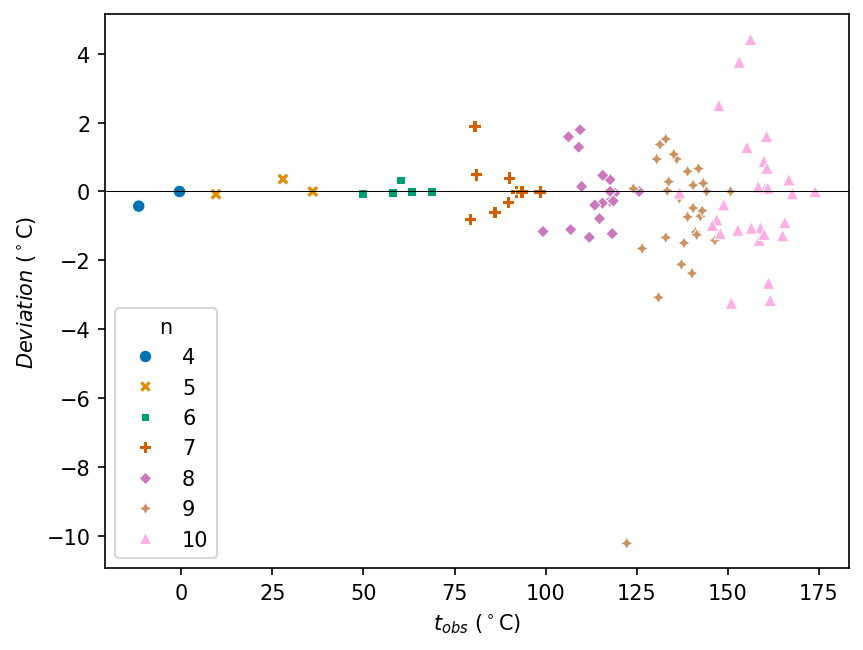

In [53]:
# Plot the deviation against t observed
seaborn.scatterplot(
    data=df_pd, x="t_obs °C", y="Deviation °C", hue="n", palette="colorblind", style="n"
)

plt.xlabel(t_obs_label)
plt.ylabel(dev_C_label)

# Plot Deviation (y) = 0 line
plt.axhline(0, color="black", linewidth=0.5)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
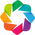

* using Mol_b64
* add img:               (   94 |   27)


:Scatter   [t_obs °C]   (Deviation °C,Compound_Id,Image,n)
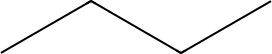
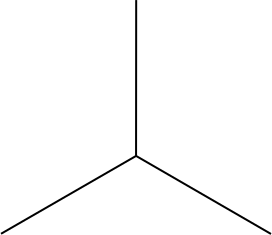
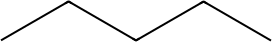
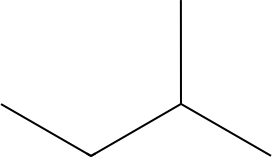
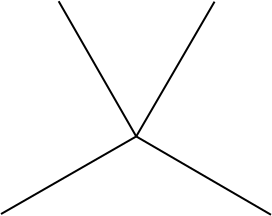
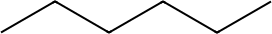
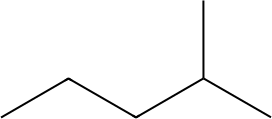
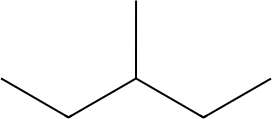
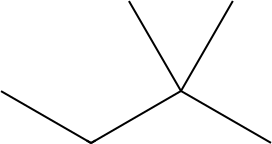
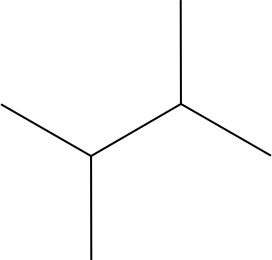
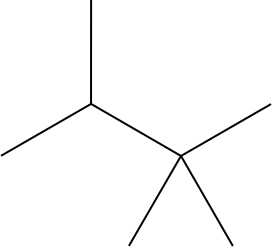
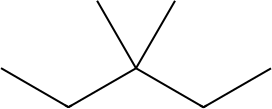
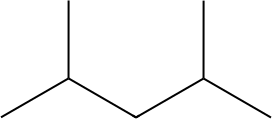
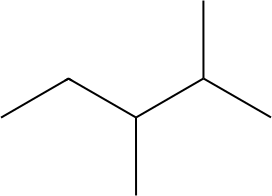
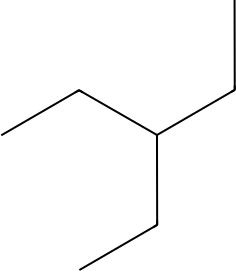
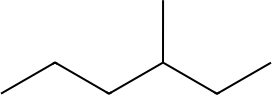
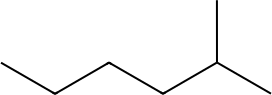
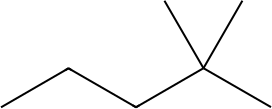
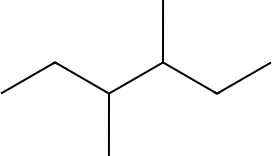
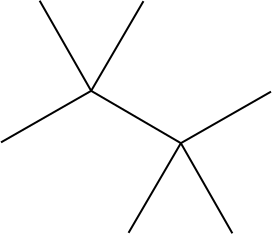
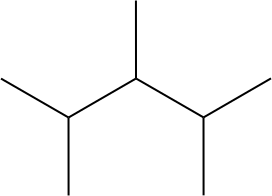
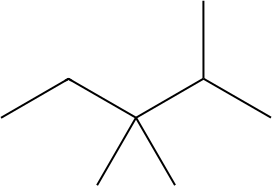
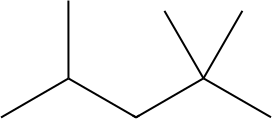
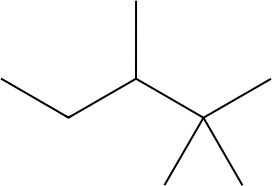
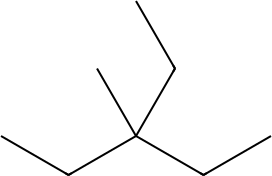
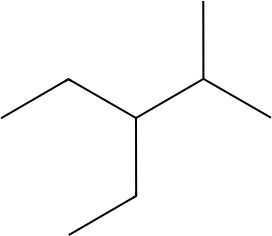
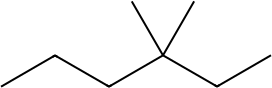
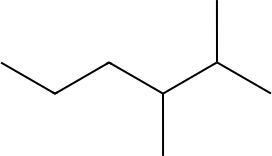
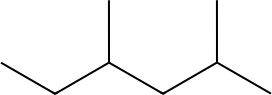
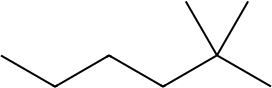
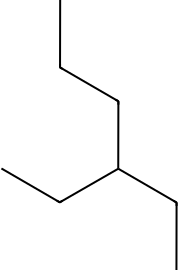
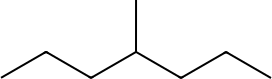
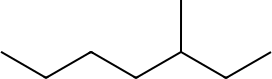
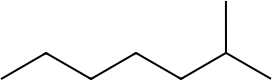
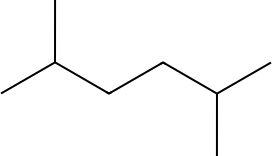
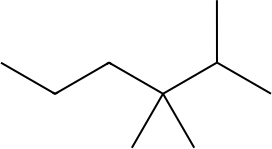
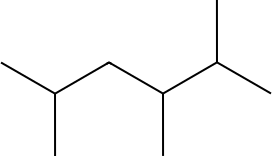
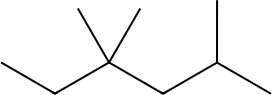
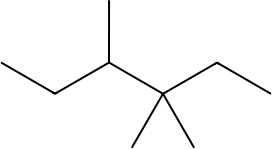
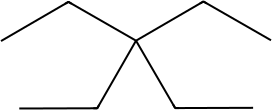
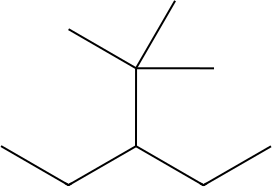
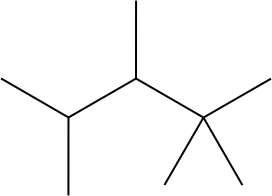
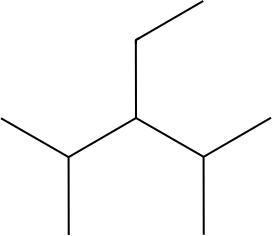
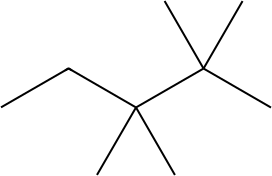
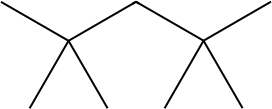
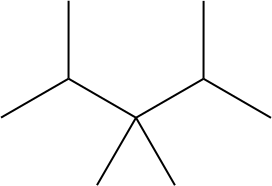
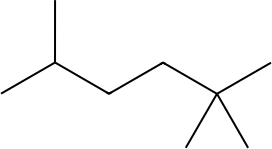
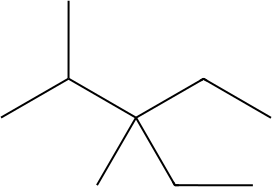
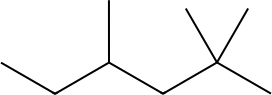
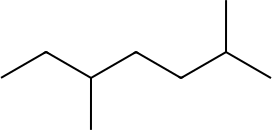
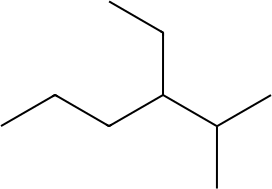
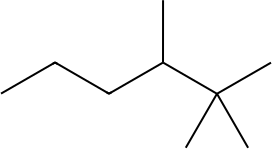
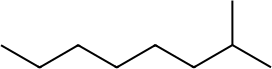
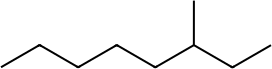
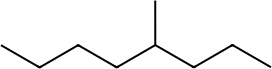
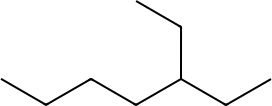
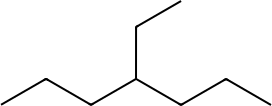
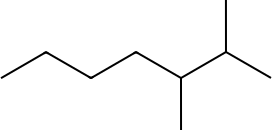
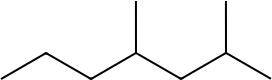
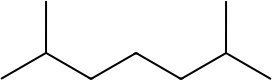
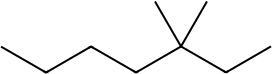
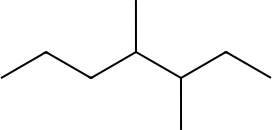
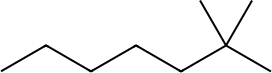
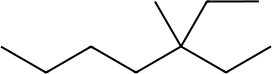
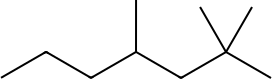
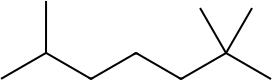
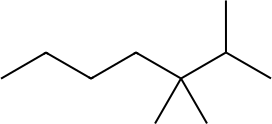
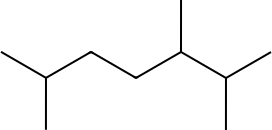
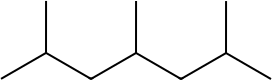
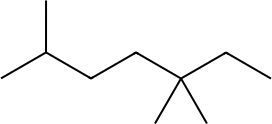
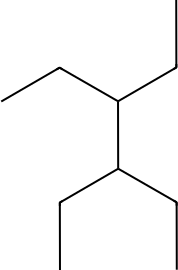
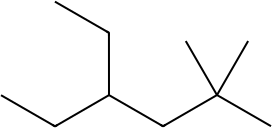
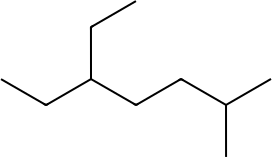
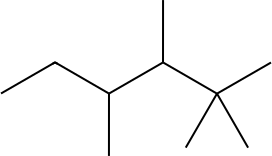
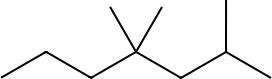
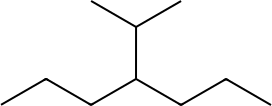
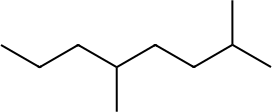
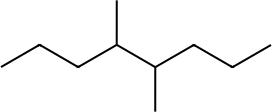
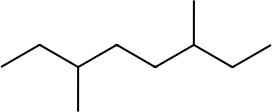
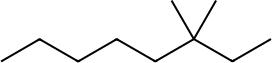
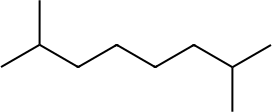
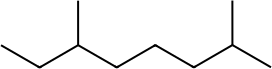
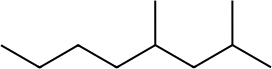
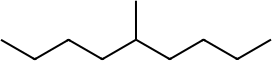
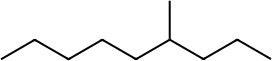
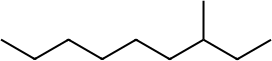
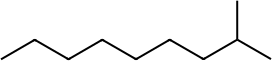
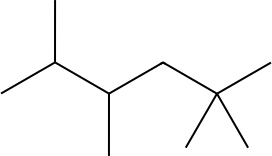
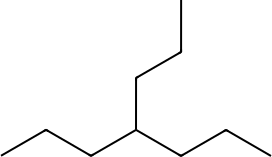
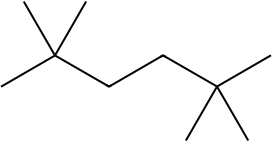

In [54]:
%%output filename="df_deviation_mol_frame_scatter"
hv.extension('bokeh')
df_mf.scatter("t_obs °C", "Deviation °C", colorby="n")

## Average Deviations in Calculated vs. Observed Boiling Points

Wiener calculates the average absolute deviation of boiling point (calculated vs. observed) for several sets of molecules:


*   Table II: 0.47°C
*   29 nonanes: 1.26°C
*   28 decanes: 1.30°C
*   All 94 compounds: 0.97°C

Using [Polars' `group_by`](https://docs.pola.rs/py-polars/html/reference/dataframe/api/polars.DataFrame.group_by.html) method, we can select those sets of compounds, then find their average deviation.

Here are the average deviations grouped by table:

In [55]:
q_table = (
    df.lazy()
    .group_by("table")
    .agg(
        [
            pl.count(),
            pl.mean("Absolute Deviation °C").round(2),
        ]
    )
    .sort("table")
)

df_table = q_table.collect()
df_table

table,count,Absolute Deviation °C
str,u32,f64
"""II""",37,0.5
"""III""",57,1.28


The average deviation for table II is slightly different than Wiener reported. The minor discrepancy may be due to Wiener rounding. There is also a typo in table II: the deviation for 2,3,4-Triraethylpentane is given as -3 when it should be -0.3, which may have occurred in typesetting rather than the original manuscript.

Here are the average deviations grouped by $n$:

In [56]:
q_n = (
    df.lazy()
    .group_by("n")
    .agg(
        [
            pl.count(),
            pl.mean("Absolute Deviation °C").round(2),
        ]
    )
    .sort("n")
)

df_n = q_n.collect()
df_n

n,count,Absolute Deviation °C
i64,u32,f64
4,2,0.21
5,3,0.15
6,5,0.09
7,9,0.5
8,18,0.7
9,29,1.27
10,28,1.3


Our values for nonanes and decanes agree with Wiener's.

In [57]:
df.select(value_mean=pl.mean("Absolute Deviation °C").round(2))

value_mean
f64
0.97


Our value for all 94 compounds agrees with Wiener's.

## Patterns Across Structural Isomers for Boiling Points

In the last section of his paper, Wiener considers how the path number (Wiener index) and polarity number lead to patterns across structural isomers. Here we reproduce Wiener's series (b) of octanes. Down the series (rightward in the following graphs), a methyl group is moved from position 1 to 2 to 3 to 4 on n-heptane. (Having a methyl group at the 1 position of n-heptane is equivalent to n-octane.)

In [58]:
df.head()

Compound_Id,molecule,table,Smiles,t_read_in,t_which,CanonicalSMILES,omega,p,n,molecule_lin_alkane,t0_obs °C,Smiles_lin_alkane,omega0,p0,Compound_Id_lin_alkane,t0_calc,t_obs °C,Δt_obs °C,Δomega,Δp,Δt_calc °C,t_calc °C,Deviation °C,Absolute Deviation °C
u32,str,str,str,f64,str,str,i64,i64,i64,str,f64,str,i64,i64,i64,f64,f64,f64,i64,i64,f64,f64,f64,f64
1,"""n-Butane""","""II""","""CCCC""",0.0,"""Δt""","""CCCC""",10,1,4,"""n-Butane""",-0.5,"""CCCC""",10,1,4,-0.423735,-0.5,0.0,0,0,0.0,-0.423735,0.0,0.0
2,"""2-Methylpropan…","""II""","""CC(C)C""",11.2,"""Δt""","""CC(C)C""",9,0,4,"""n-Butane""",-0.5,"""CCCC""",10,1,4,-0.423735,-11.7,11.2,1,1,11.625,-12.048735,-0.425,0.425
3,"""n-Pentane""","""II""","""CCCCC""",0.0,"""Δt""","""CCCCC""",20,2,5,"""n-Pentane""",36.1,"""CCCCC""",20,2,5,35.988965,36.1,0.0,0,0,0.0,35.988965,0.0,0.0
4,"""2-Methylbutane…","""II""","""CC(C)CC""",8.2,"""Δt""","""CCC(C)C""",18,2,5,"""n-Pentane""",36.1,"""CCCCC""",20,2,5,35.988965,27.9,8.2,2,0,7.84,28.148965,0.36,0.36
5,"""2,2-Dimethylpr…","""II""","""CC(C)(C)C""",26.6,"""Δt""","""CC(C)(C)C""",16,0,5,"""n-Pentane""",36.1,"""CCCCC""",20,2,5,35.988965,9.5,26.6,4,2,26.68,9.308965,-0.08,0.08


In [59]:
octanes_methyl_molecules = [
    "n-Octane",
    "2-Methylheptane",
    "3-Methylheptane",
    "4-Methylheptane",
]
octanes_moving_methyl = df.filter(pl.col("molecule").is_in(octanes_methyl_molecules))

octanes_moving_methyl = octanes_moving_methyl.with_columns(
    [
        pl.col("molecule").str.slice(0,1).alias("first char"),
    ]
)

positions = ("2", "3", "4", "5", "6", "7", "8", "9")

octanes_moving_methyl = octanes_moving_methyl.with_columns(
    [
        pl.when(pl.col("first char").is_in(positions))
        .then(pl.col("first char"))
        .otherwise(pl.lit("1"))
        .alias("methyl position str"),
    ]
)
octanes_moving_methyl = octanes_moving_methyl.with_columns(
    [
        pl.col("methyl position str").cast(pl.Int64).alias("methyl position"),
    ]
)
octanes_moving_methyl.select(
    ["molecule", "n", "CanonicalSMILES", "omega", "p", "methyl position", "t_calc °C"]
)

molecule,n,CanonicalSMILES,omega,p,methyl position,t_calc °C
str,i64,str,i64,i64,i64,f64
"""n-Octane""",8,"""CCCCCCCC""",84,5,1,125.658393
"""2-Methylheptan…",8,"""CCCCCC(C)C""",79,5,2,118.002143
"""3-Methylheptan…",8,"""CCCCC(C)CC""",76,6,3,118.908393
"""4-Methylheptan…",8,"""CCCC(C)CCC""",75,6,4,117.377143


As Wiener writes, the calculated boiling points alternate as the methyl position is varied: the boiling point


1.   decreases about 7.7°C from position 1 to 2 as $\omega$ decreases by five
2.   increases about 0.9°C from position 2 to 3 as $p$ increases by one while $\omega$ decreases by three
3.   decreases about 1.5°C from position 3 to 4 as $\omega$ decreases by one



Wiener interprets the path number (Wiener index) as a measure of compactness: "The smaller this total distance, the larger is the compactness of the molecule." As a result, he notes that less energy will be lost due to intermolecular collisions as the compound is heated, thus focusing more energy towards vaporization, which decreases the boiling point.

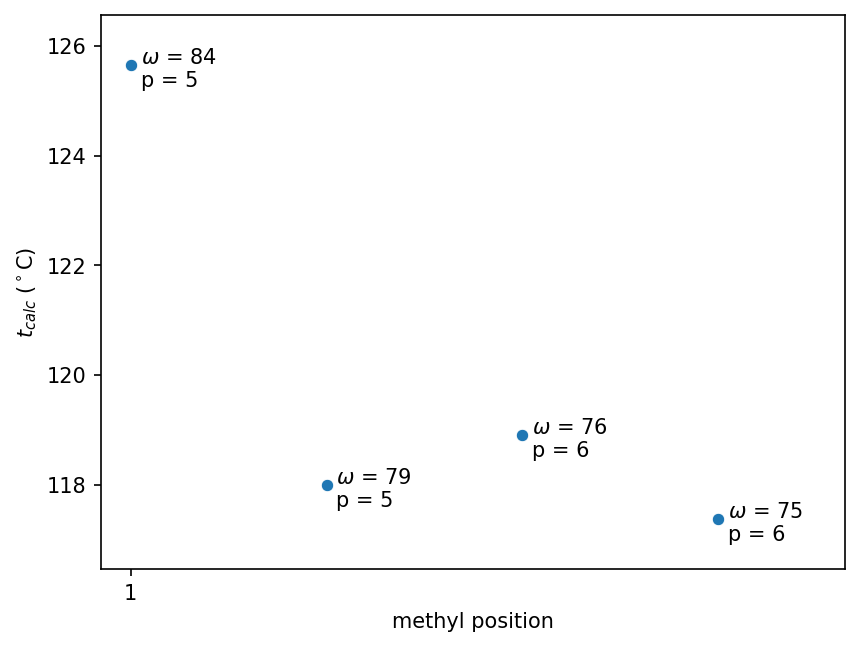

In [60]:
# Convert to pandas manually because automatic conversion fails in Google Colab for some reason
octanes_moving_methyl_pd = octanes_moving_methyl.to_pandas()

# Plot the calculated boiling point against methyl position
plt.ylabel(t_calc_label)
s = seaborn.scatterplot(data=octanes_moving_methyl_pd, x="methyl position", y="t_calc °C")

# Create integer tick labels for methyl position by passing in list of integers
methyl_pos_col = octanes_moving_methyl.select("methyl position")
methyl_pos = methyl_pos_col.to_numpy().tolist()
s.set_xticks(methyl_pos[0])

## Label data points with omega and p values
# Allow enough space for labels to the right of rightmost data point
#   and above uppermost data point
x_range = plt.xlim()
plt.xlim(x_range[0], x_range[1] + 0.5)
y_range = plt.ylim()
plt.ylim(y_range[0] - 0.5, y_range[1] + 0.5)

# Annotate plot with labels
for row_num, isomer in enumerate(
    octanes_moving_methyl.select(
        ["omega", "p", "methyl position", "t_calc °C"]
    ).iter_rows()
):
    plt.annotate(
        f"$\omega$ = {isomer[0]}\np = {isomer[1]}", (isomer[2] + 0.05, isomer[3] - 0.4)
    )

In [61]:
# Prepare dataframe for plotting with mol_frame
octanes_moving_methyl_mf = mf.MolFrame(octanes_moving_methyl_pd)
octanes_moving_methyl_mf = octanes_moving_methyl_mf.add_b64()

* using Smiles
* add b64:               (    4 |   29)


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
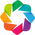

* using Mol_b64
* add img:               (    4 |   30)


:Scatter   [methyl position]   (t_calc °C,Compound_Id,Image)
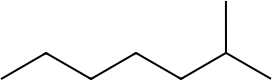
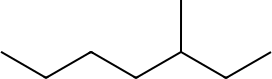
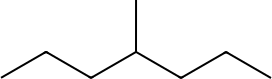

In [62]:
%%output filename="octanes_moving_methyl_mol_frame_scatter"
hv.extension('bokeh')
octanes_moving_methyl_mf.scatter("methyl position", "t_calc °C")

## Concluding Thoughts

Reviewing Wiener's classic paper made me appreciate the advances in cheminformatics, particularly the digital advances. Where Wiener might have manually calculated each value, we can use dataframes and code to calculate many values, and graphing tools to visualize the results. It also points out the achievement of Wiener recognizing the patterns given the difficulty of computing the data without modern tools.

## Notes

If we wanted to extract data from many papers, it would be worthwhile to automate more of this process. It would probably be possible to prepare (for example, extract) each table separately and clean (correct optical character recognition mistakes) the data with AI tools such as [ChemDataExtractorv2](http://chemdataextractor2.org/) and [ChatGPT](https://openai.com/blog/chatgpt). You could also use regular expressions to correct classes of typos, for example changing the typo I (uppercase "eye") to l (lowercase "el") in "Ihexane", "Iheptane", and "Ioctane".

If we wanted to prioritize speed over modular code, we could combine the functions to calculate the Wiener index and polarity number because each uses [RDKit's GetDistanceMatrix](https://www.rdkit.org/docs/source/rdkit.Chem.rdmolops.html?highlight=getdistancematrix#rdkit.Chem.rdmolops.GetDistanceMatrix) function.

## Postscript

2024-02: Thanks to thomasaarholt, deanm0000, and abstractqqq on the [Polars Discord](https://discord.com/channels/908022250106667068), and [jqurious on StackOverflow](https://stackoverflow.com/users/19355181/jqurious), for suggestions for improving the Polars code.